# Effect of $\sigma_0^2$

## Packages

In [1]:
try:
    import os

    from google.colab import drive
    drive.mount('/content/gdrive')

    os.chdir( '/content/gdrive/My Drive/Colab Notebooks/GoA/02_binary/' )
    !ls
except Exception:
    pass

In [2]:
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import model_from_json

from CommVAEBinary import CommVAEBinary

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # For calculating QPSK decoding
from functools import reduce

import datetime, itertools, dill

In [3]:
# The one who steals the data
def robinhood(fig, filename, col_dtype=[float, float], col_fmt=None):
    assert (len(fig.axes) < 2), "More than one axis not supported"
    ax = fig.axes[0]
    
    header = []
    fmt = []
    
    # Don't modify the argument here, it will get updated for all the following calls
    if not col_fmt:
        _col_fmt = [ "%d" if d == int else "%.5f" for d in col_dtype ]
    else:
        _col_fmt = col_fmt.copy()
    
    n_lines = len(ax.lines)
    x_data = ax.lines[0].get_xdata()
    
    data = np.zeros((x_data.shape[0], 2 * n_lines))
    
    for(i, line) in enumerate(ax.lines):
        data[:, 2*i] = line.get_xdata()
        data[:, 2*i+1] = line.get_ydata()
        
        header += ["x_" + line.get_label(), "y_" + line.get_label()]
        fmt += _col_fmt
            
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(",".join(header) + "\n")
            np.savetxt(f, data, delimiter=",", fmt=",".join(fmt))

### Evaluate for models

In [4]:
inVecDim = 5
encDim = 2
models = {
#     # "AWGN_S0100_00": "./models_32x01_sigma0_2/AWGN_s0100_00",
#     "AWGN_S0100": "./models_32x01_sigma0_2/AWGN_s0100_01", #!
#     # "AWGN_S0100_02": "./models_32x01_sigma0_2/AWGN_s0100_02",
    
#     # "AWGN_S0200_00": "./models_32x01_sigma0_2/AWGN_s0200_00",
#     # "AWGN_S0200_01": "./models_32x01_sigma0_2/AWGN_s0200_01",
#     "AWGN_S0200": "./models_32x01_sigma0_2/AWGN_s0200_02", #!
    
#     # "AWGN_S0300_00": "./models_32x01_sigma0_2/AWGN_s0300_00",
#     # "AWGN_S0300_01": "./models_32x01_sigma0_2/AWGN_s0300_01",
#     "AWGN_S0300": "./models_32x01_sigma0_2/AWGN_s0300_02", #!
    
#     # "AWGN_S0400_00": "./models_32x01_sigma0_2/AWGN_s0400_00",
#     "AWGN_S0400": "./models_32x01_sigma0_2/AWGN_s0400_01", #!
#     # "AWGN_S0400_02": "./models_32x01_sigma0_2/AWGN_s0400_02",
    
    # "AWGN_S0500_00": "./models_32x01_sigma0_2/AWGN_s0500_00",
    # "AWGN_S0500_01": "./models_32x01_sigma0_2/AWGN_s0500_01", #!
    # "AWGN_S0500_02": "./models_32x01_sigma0_2/AWGN_s0500_02",
#     "AWGN_S0500": "./models_32x01/model_32symbols_gray_awgn_s050", #!
    
#     # "AWGN_S1000_00": "./models_32x01_sigma0_2/AWGN_s1000_00",
#     "AWGN_S1000": "./models_32x01_sigma0_2/AWGN_s1000_01", #!
#     # "AWGN_S1000_02": "./models_32x01_sigma0_2/AWGN_s1000_02"
    
#     "AWGN_S0750": "./models_32x01_sigma0_2/AWGN_s0750_00", #!
#     # "AWGN_S0750_01": "./models_32x01_sigma0_2/AWGN_s0750_01",
#     # "AWGN_S0750_02": "./models_32x01_sigma0_2/AWGN_s0750_02"
    
    # "S0010_00": "./models_32x01_sigma0_2/RBF_s0010_00",
    "S0010": "./models_32x01_sigma0_2/RBF_s0010_01", #!
    # "S0010_02": "./models_32x01_sigma0_2/RBF_s0010_02",
    
    # "S0050_00": "./models_32x01_sigma0_2/RBF_s0050_00",
    "S0050": "./models_32x01_sigma0_2/RBF_s0050_01", #!
    # "S0050_02": "./models_32x01_sigma0_2/RBF_s0050_02",
    
    # "S0075_00": "./models_32x01_sigma0_2/RBF_s0075_00",
    "S0075": "./models_32x01_sigma0_2/RBF_s0075_01", #!
    # "S0075_02": "./models_32x01_sigma0_2/RBF_s0075_02",
    
    # "S0100_00": "./models_32x01_sigma0_2/RBF_s0100_00",
    "S0100": "./models_32x01_sigma0_2/RBF_s0100_01", #!
    # "S0100_02": "./models_32x01_sigma0_2/RBF_s0100_02",
    
    # "S0200_00": "./models_32x01_sigma0_2/RBF_s0200_00", # <-
    "S0200": "./models_32x01_sigma0_2/RBF_s0200_01", #!
    # "S0200_02": "./models_32x01_sigma0_2/RBF_s0200_02",
    
    # "S0300_00": "./models_32x01_sigma0_2/RBF_s0300_00",
    "S0300": "./models_32x01_sigma0_2/RBF_s0300_01", #!
    # "S0300_02": "./models_32x01_sigma0_2/RBF_s0300_02",
    
    # "S0400_00": "./models_32x01_sigma0_2/RBF_s0400_00",
    "S0400": "./models_32x01_sigma0_2/RBF_s0400_01", #!
    # "S0400_02": "./models_32x01_sigma0_2/RBF_s0400_02",
    
    # "S0500_00": "./models_32x01_sigma0_2/RBF_s0500_00",
    "S0500": "./models_32x01_sigma0_2/RBF_s0500_01", #!
    # "S0500_02": "./models_32x01_sigma0_2/RBF_s0500_02",
    # "S0500_AA": "./models_32x01/model_32symbols_gray_awgn_s050", #!
}

SNR_range_dB = np.arange( 0.0, 16.0, 1.0 )
results = {}

W0120 11:49:02.873377 140387143911168 deprecation.py:506] From /opt/Miniconda2/envs/tf-1.14-generic/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0120 11:49:03.010247 140387143911168 deprecation.py:323] From /opt/Miniconda2/envs/tf-1.14-generic/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0120 11:49:03.160462 140387143911168 training_utils.py:1101] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expe

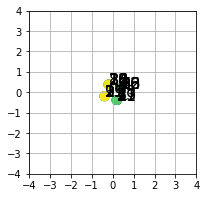

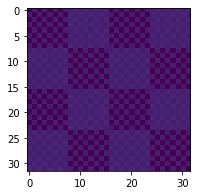

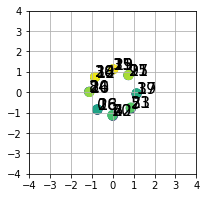

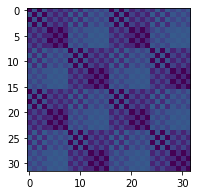

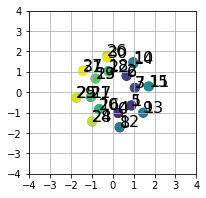

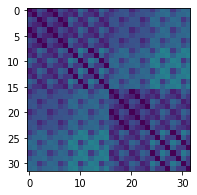

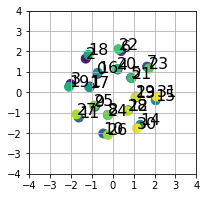

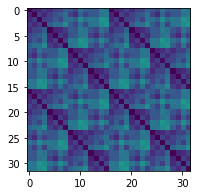

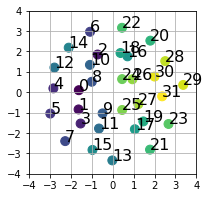

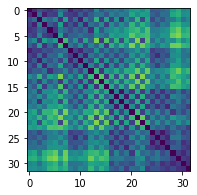

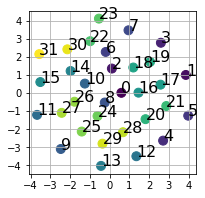

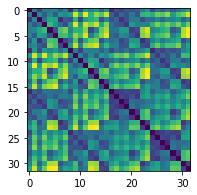

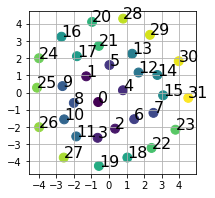

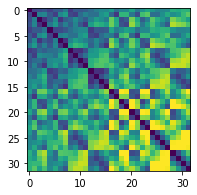

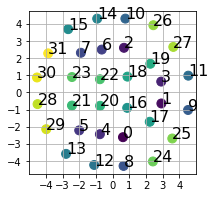

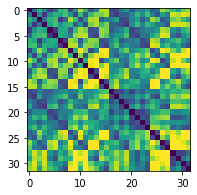

In [5]:
# fig, ax = plt.subplots(nrows=len(models), ncols=2, figsize=(3.0*2, 3.0*len(models)))
for idx, (model_label, model_file) in enumerate(models.items()):
    # Clear any old models
    try:
      K.clear_session()
      del model
    except:
      pass
    
    model = CommVAEBinary()
    model.load_model(model_file)
    m_points = model.get_constellation()
    m_pow = np.mean(np.sum(m_points*m_points,axis=1))
#     m_points = np.sqrt(1.0/m_pow) * m_points
#     m_pow = np.mean(np.sum(m_points*m_points,axis=1))

    # Plot constellation
    fig_const = plt.figure(figsize=(3.0, 3.0))
    chDim = model.latent_dim//2
    for i in range(chDim):
      plt.scatter(m_points[:,i], m_points[:,i+chDim], c=np.arange(2**model.in_dim), s=80)
      for j in range(2**model.in_dim):
        plt.annotate( j, (m_points[j,i],m_points[j,i+chDim]), size=16)
    #     # trick to avoid overlap during cheating
    #     ax1.annotate( "{:2d}".format(j) if j < 16 else "    {:2d}".format(j), (m2_points[j,i],m2_points[j,i+chDim]), size=16)
    plt.grid()
    plt.xticks(np.arange(-4.0,4.1,1.0))
    plt.yticks(np.arange(-4.0,4.1,1.0))
#     plt.xlabel("I", fontdict={'fontsize':16})
#     plt.ylabel("Q", fontdict={'fontsize':16})
#     plt.title(model_label)
    plt.savefig("gray_const{:02d}x{:02d}_{}.pdf".format(inVecDim, chDim, model_label), format='pdf', bbox_inches='tight')
    
    # Plot distance matrix
    fig_dist = plt.figure(figsize=(3.0, 3.0))
    plt.imshow(cdist(m_points,m_points), vmin=0, vmax=8.0)
    plt.savefig("gray_cdist{:02d}x{:02d}_{}.pdf".format(inVecDim, chDim, model_label), format='pdf', bbox_inches='tight')
    
    ## Check BLER
    noisePower = m_pow * 10.0**(-SNR_range_dB/10.0)
    n0_per_comp = noisePower/model.latent_dim

    err = []
    for n0 in n0_per_comp:
      thisErr = 0
      thisCount = 0
      while thisErr < 5000:
        txBlk = np.random.randint(2, size=(1000,model.in_dim))
        txTest, _ = model.encode(txBlk)
        rxTest = txTest + np.random.normal(scale=np.sqrt(n0), size=txTest.shape)
        rxDecode = model.decode(rxTest)
        rxBlk = np.where(rxDecode>0.5, 1, 0 )
        # thisErr += txBlk.shape[0]-np.sum(np.prod(rxBlk==txBlk,axis=1))
        thisErr += np.sum(rxBlk!=txBlk)
        thisCount += (1000*model.in_dim)
      err.append(thisErr/thisCount)
    results[model_label] = { 
        "ber": np.array(err),
        "n0": model.n0/model.latent_dim,
        "sigma0_2": int(model_label[1:])/100, # because we didn't save sigma_0^2 in model
        "pow": m_pow
    }

### Traditional Methods
Load the constellation data from prespecified files and find BLER.

In [6]:
results_traditional = {}

d_min: 0.4472135954999579
En: 5.0


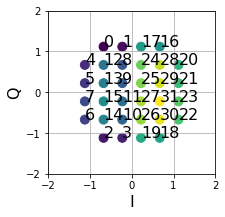

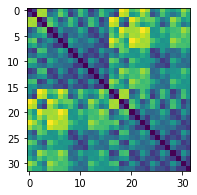

In [7]:
qam_map = np.genfromtxt("./../AWGN/sphere_data/{:03d}x{:03d}_qam_gray.csv".format(2**inVecDim,encDim))
qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
qam_map = np.sqrt(1.0/qam_sym_pow) * qam_map
# print( "QAM Avg. Tx Power:", qam_sym_pow )

# noisePower = qam_sym_pow * 10.0**(-SNR_range_dB/10.0)
noisePower = 1.0 * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/encDim

qam_d_min = np.unique(cdist(qam_map,qam_map))[1]
print("d_min:", qam_d_min )

# qam_en = qam_sym_pow / (qam_d_min**2)
qam_en = 1.0 / (qam_d_min**2)
print("En:", qam_en)

# Plot constellation
fig_const = plt.figure(figsize=(3.0, 3.0))
chDim = encDim//2
for i in range(chDim):
  plt.scatter(qam_map[:,i], qam_map[:,i+chDim], c=np.arange(2**inVecDim), s=80)
  for j in range(2**inVecDim):
    plt.annotate( j, (qam_map[j,i],qam_map[j,i+chDim]), size=16)
#     # trick to avoid overlap during cheating
#     ax1.annotate( "{:2d}".format(j) if j < 16 else "    {:2d}".format(j), (m2_points[j,i],m2_points[j,i+chDim]), size=16)
plt.grid()
plt.xticks(np.arange(-2.0,2.1,1.0))
plt.yticks(np.arange(-2.0,2.1,1.0))
plt.xlabel("I", fontdict={'fontsize':16})
plt.ylabel("Q", fontdict={'fontsize':16})
plt.savefig("gray_const{:02d}x{:02d}_qam.pdf".format(inVecDim, chDim), format='pdf', bbox_inches='tight')

# Plot distance matrix
fig_cdist = plt.figure(figsize=(3.0, 3.0))
plt.imshow(cdist(qam_map,qam_map))
plt.savefig("gray_cdist{:02d}x{:02d}_qam.pdf".format(inVecDim, chDim), format='pdf', bbox_inches='tight')

In [8]:
err = []
for n0 in n0_per_comp:
  thisErr = 0
  thisCount = 0

  while thisErr < 5000:
    txSym = np.random.randint(2**inVecDim, size=1000)
    txTest = qam_map[txSym]
    rxTest = txTest + np.random.normal(scale=np.sqrt(n0), size=txTest.shape)
    rxDecode = cdist(rxTest, qam_map)
    rxSym = np.argmin(rxDecode,axis=1)
    # thisErr += np.sum(rxSym!=txSym)
    thisErr += reduce(lambda x1, x2: x1 + x2, map(lambda x: bin(x).count("1"), rxSym ^ txSym))
    thisCount += (1000 * inVecDim)
  err.append(thisErr/thisCount)

results_traditional["QAM"] = {
    "en": qam_en,
    "dmin": qam_d_min,
    "sym_pow": qam_sym_pow,
    "ber": np.array(err)
}

Agrell Avg. Tx Power: 4503.0
d_min: 0.47686890538205073
En: 4.397460937500002


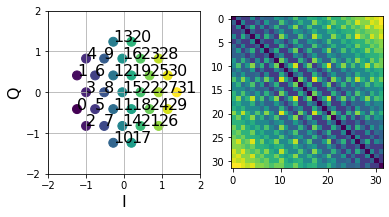

In [9]:
agrell_map = np.genfromtxt("./../AWGN/sphere_data/{:03d}x{:03d}_agrell.csv".format(2**inVecDim,encDim))
agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
agrell_map = np.sqrt(1.0/agrell_sym_pow) * agrell_map
print( "Agrell Avg. Tx Power:", agrell_sym_pow )

# noisePower = agrell_sym_pow * 10.0**(-SNR_range_dB/10.0)
noisePower = 1.0 * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/encDim

agrell_d_min = np.unique(cdist(agrell_map,agrell_map))[1]
print("d_min:", agrell_d_min )

# agrell_en = agrell_sym_pow / (agrell_d_min**2)
agrell_en = 1.0 / (agrell_d_min**2)
print("En:", agrell_en)

# Plot constellation
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(3.0*2, 3.0))
chDim = encDim//2
for i in range(chDim):
  ax[0].scatter(agrell_map[:,i], agrell_map[:,i+chDim], c=np.arange(2**inVecDim), s=80)
  for j in range(2**inVecDim):
    ax[0].annotate( j, (agrell_map[j,i],agrell_map[j,i+chDim]), size=16)
#     # trick to avoid overlap during cheating
#     ax1.annotate( "{:2d}".format(j) if j < 16 else "    {:2d}".format(j), (m2_points[j,i],m2_points[j,i+chDim]), size=16)
ax[0].grid()
ax[0].set_xticks(np.arange(-2.0,2.1,1.0))
ax[0].set_yticks(np.arange(-2.0,2.1,1.0))
ax[0].set_xlabel("I", fontdict={'fontsize':16})
ax[0].set_ylabel("Q", fontdict={'fontsize':16})

# Plot distance matrix
ax[1].imshow(cdist(agrell_map,agrell_map))

In [10]:
err = []
for n0 in n0_per_comp:
  thisErr = 0
  thisCount = 0
  
  while thisErr < 5000:
    txSym = np.random.randint(2**inVecDim, size=1000)
    txTest = agrell_map[txSym]
    rxTest = txTest + np.random.normal(scale=np.sqrt(n0), size=txTest.shape)
    rxDecode = cdist(rxTest, agrell_map)
    rxSym = np.argmin(rxDecode,axis=1)
    # thisErr += np.sum(rxSym!=txSym)
    thisErr += reduce(lambda x1, x2: x1 + x2, map(lambda x: bin(x).count("1"), rxSym ^ txSym))
    thisCount += (1000 * inVecDim)
  err.append(thisErr/thisCount)

results_traditional["Agrell"] = {
    "en": agrell_en,
    "d_min": agrell_d_min,
    "sym_pow": agrell_sym_pow,
    "ber": np.array(err)
}

### Plot Results

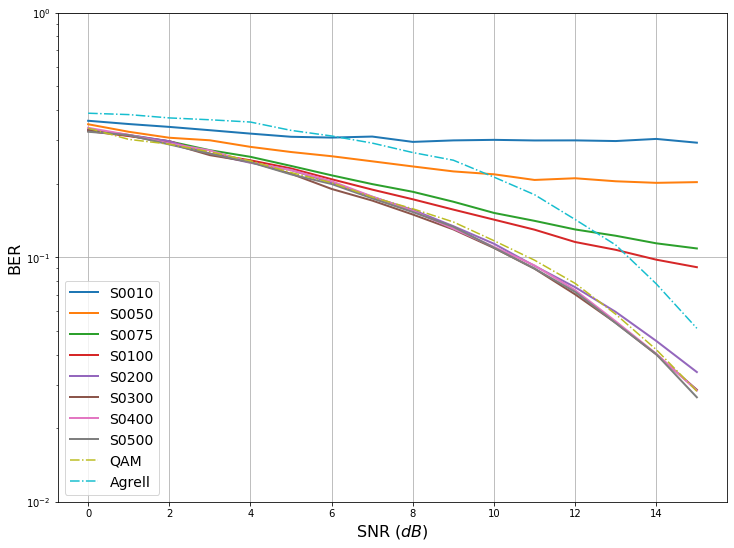

In [11]:
# colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(8*1.5,6*1.5))

for (label, result) in results.items():
    plt.semilogy(SNR_range_dB, 
                 result["ber"], 
                 label=label, 
                 linewidth=2,
                 linestyle=":" if "Oshea" in label or "[1]" in label else "-")

plt.semilogy(SNR_range_dB, results_traditional["QAM"]["ber"], label="QAM",linestyle="-.")
# plt.semilogy(SNR_range_dB, results_traditional["Agrell"]["bler"], label="Agrell [17]", color=next(colors), linestyle="-.")
plt.semilogy(SNR_range_dB, results_traditional["Agrell"]["ber"], label="Agrell", linestyle="-.")

plt.legend(loc="lower left", prop={'size':14})
plt.grid()
# plt.title("Best observed BLER of trained models", fontdict={'fontsize':18})
plt.xlabel("SNR ($dB$)", fontdict={'fontsize':16})
plt.ylabel("BER", fontdict={'fontsize':16})
plt.ylim((1e-2,1e0))

robinhood(fig, "gray_ber_{:02d}x{:02d}.csv".format(inVecDim,chDim), col_dtype=[int, float])

## Mutual Information

The mutual information in AWGN channel is upper bounded as
\begin{align}
    I(\textbf{X}, \hat{\textbf{Z}}) 
                &\leq \mathbb{E}_{p(\textbf{x})} \left(
                \frac{1}{2\sigma_0^2} \sum \limits_{j=1}^{m} z_j^2
                - \frac{m}{2} \left( 1 - \frac{\sigma_n^2}{\sigma_0^2} 
                + \log \frac{\sigma_n^2}{\sigma_0^2} \right) \right)
\end{align}

Compute the bound and plot for each $\sigma_0^2$.

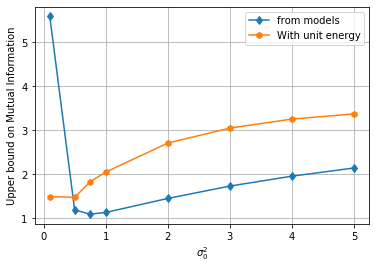

In [46]:
m = 2

plt.plot([result['sigma0_2'] for (_, result) in results.items()],
         [ 1.0/(2*result['sigma0_2']) * 1.0 - m/2.0 * (
            1.0 - result['n0']/result['sigma0_2'] + np.log(result['n0']/result['sigma0_2'])) 
          for (model_label, result) in results.items()], 
         marker='d',
         label = "from models")

plt.plot([result['sigma0_2'] for (_, result) in results.items()],
         [ 1.0/(2*result['sigma0_2']) * result['pow'] - m/2.0 * (
            1.0 - result['n0']/result['sigma0_2'] + np.log(result['n0']/result['sigma0_2'])) 
          for (model_label, result) in results.items()], 
         marker='h',
         label = "With unit energy")

plt.grid()
plt.xlabel("$\sigma_0^2$")
plt.ylabel("Upper bound on Mutual Information")
plt.legend()

(0.0, 5.0)

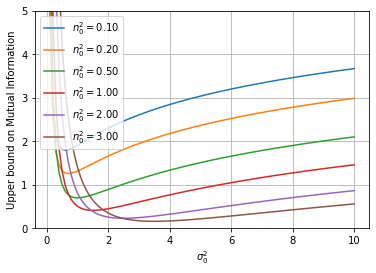

In [50]:
sigma0_2 = np.linspace(0.1, 10.0, 100)
const_pow = 1.0

n0 = 0.10
plt.plot(sigma0_2,
         [ 1.0/(2*s) * const_pow - m/2.0 * (1.0 - n0/s + np.log(n0/s)) for s in sigma0_2], 
         label = "$n_0^2 = {:.2f}$".format(n0))

n0 = 0.20
plt.plot(sigma0_2,
         [ 1.0/(2*s) * const_pow - m/2.0 * (1.0 - n0/s + np.log(n0/s)) for s in sigma0_2], 
         label = "$n_0^2 = {:.2f}$".format(n0))

n0 = 0.50
plt.plot(sigma0_2,
         [ 1.0/(2*s) * const_pow - m/2.0 * (1.0 - n0/s + np.log(n0/s)) for s in sigma0_2], 
         label = "$n_0^2 = {:.2f}$".format(n0))

n0 = 1.00
plt.plot(sigma0_2,
         [ 1.0/(2*s) * const_pow - m/2.0 * (1.0 - n0/s + np.log(n0/s)) for s in sigma0_2], 
         label = "$n_0^2 = {:.2f}$".format(n0))

n0 = 2.00
plt.plot(sigma0_2,
         [ 1.0/(2*s) * const_pow - m/2.0 * (1.0 - n0/s + np.log(n0/s)) for s in sigma0_2], 
         label = "$n_0^2 = {:.2f}$".format(n0))

n0 = 3.00
plt.plot(sigma0_2,
         [ 1.0/(2*s) * const_pow - m/2.0 * (1.0 - n0/s + np.log(n0/s)) for s in sigma0_2], 
         label = "$n_0^2 = {:.2f}$".format(n0))


plt.grid()
plt.xlabel("$\sigma_0^2$")
plt.ylabel("Upper bound on Mutual Information")
plt.legend()
plt.ylim([0.0, 5.0])